<a href="https://colab.research.google.com/github/ziatdinovmax/AtomicImageSimulator/blob/master/GenerateTrainingSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generation of synthetic atomic lattice images

Prepared by Maxim Ziatdinov

Import modules:

In [0]:
from main import *
import h5py
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# use this for notebook's dark theme
plt.style.use(['dark_background']) 

We can import already existing coordinates or we can generate our own lattice.

In [0]:
#t0, t1, t2 = 3.5, 3.85, 7.7
#l1, l2 = 100, 40
#lattice_coordinates = build_Si_lattice(t0, t1, t2, l1, l2)

In [0]:
directory = 'lattices/'
filename = 'BFO-coordinates-clean.npy'
lattice_coordinates = np.load(directory+filename)

We are now going to simulate an image from these coordinates. First, we specify some parameters for image simulation:

In [0]:
# nearest neighbor distance
nnd = 1.5
# angstrom to pixel conversion coefficient (do not change)
ang2px = 10.5
# angle to rotate
ang = (0, 180, 5)
# atom "width" (better to keep it below 15)
sc = [11, 13, 15] 
# number of holes to be introduced
n_holes = 5
# size of the largest hole (in the nn distance units)
r_hole = 5
# random displacement of atomic poision (0 to 1)
randomize = .25
# blurring due to overlap with a probe
convprobe = 1.5
# Type of impurity 1
impurity1 = 'Na'
# Type of impurity 2
impurity2 = 'Si'
# Amount of impurity 1
n_impurity1 = 0
# Amount of impurity 2
n_impurity2 = 0

Now we simulate an image itself:

In [0]:
sl = SimulateLattice(
    lattice_coordinates, ang2px, ang, sc, nnd,
    randomize, convprobe, n_holes, r_hole,
    impurity1, impurity2, n_impurity1, n_impurity2)
imgsrc, mask = sl.make_image()

Plot a result:

(0, 1370)

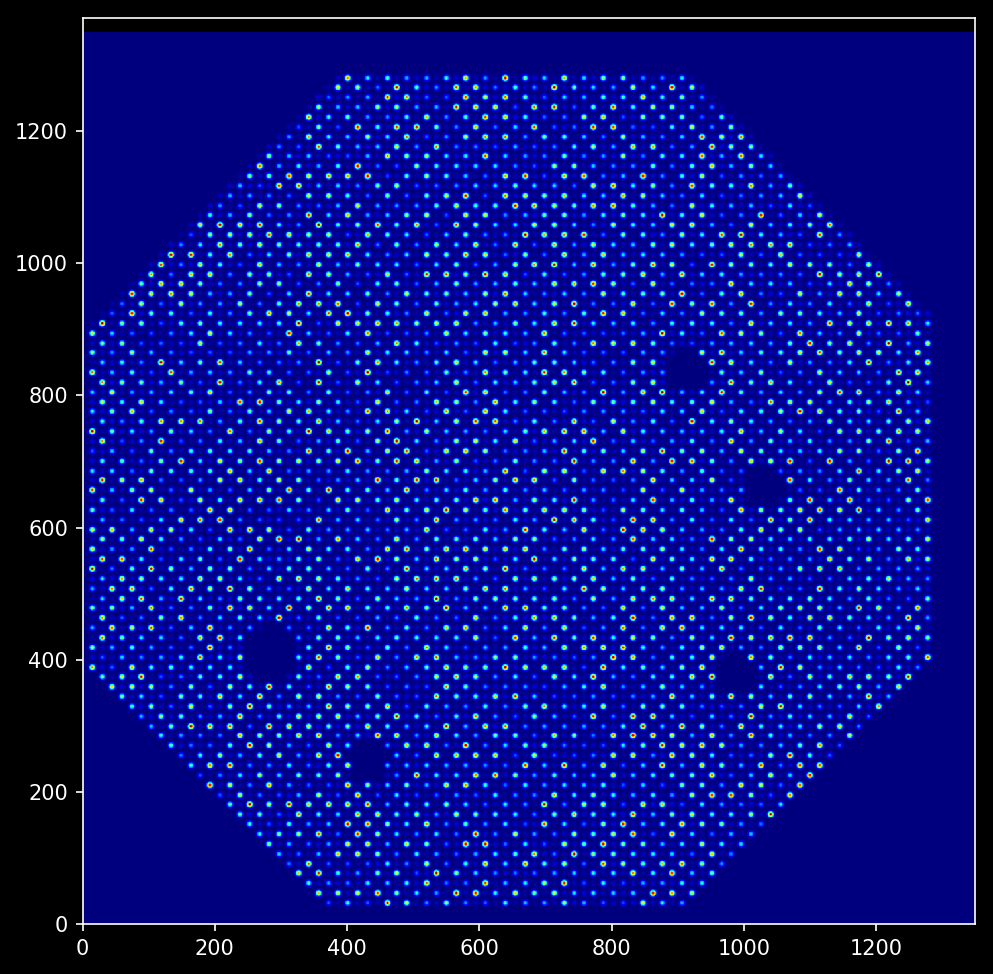

In [14]:
plt.figure(figsize=(8, 8), dpi = 150)
plt.imshow(imgsrc, cmap = 'jet')
#plt.imshow(mask[:,:,0], interpolation='Gaussian', alpha=0.4)
plt.xlim(0, imgsrc.shape[0])
plt.ylim(0, imgsrc.shape[1])

We can next perform a data augmentation procedure. First, we produce a stack of cropped images by sliding a window of size $w \times h$ across the original image with a step of size $s$ and extracting the image portion that ovelpaps with the window at each step. Then we apply various transformations/distortions (such as different forms of noise) to each image in the stack.

Note: If you don't want a certain transformation to be applied, just remove it from data_transform initialization.

In [0]:
# Define parameters of image croppping
window_size = (256, 256)
step_size = 128
batch_size = 5
# Define image distortion/noise parameters
zoom = (64, 128+16, 16)
scars = False
resize = 256
# Noise parameters are defined as dictionary
noise_dict = {}
noise_dict['poisson'] = (65, 80)
noise_dict['gauss'] = (0, 400)
noise_dict['blur'] = (0, 12)
noise_dict['contrast'] = (5, 20)
noise_dict['salt and pepper'] = (0, 10)

Define a function for batch generation:

TODO: define it properly in utils.py

In [0]:
def generate_batches(batch_size, lattice_coordinates, randomize,
                     n_impurity1, n_impurity2):
    
    sl = SimulateLattice(lattice_coordinates, ang2px, ang, sc,
                 nnd, randomize, convprobe, n_holes, r_hole,
                 impurity1, impurity2, n_impurity1, n_impurity2)
    imgsrc, mask = sl.make_image()
    imcrop = cropper(imgsrc, mask, window_size, step_size, batch_size)
    images, labels = imcrop.imgen()
    imaug = data_transform(
        batch_size, window_size[0], window_size[1],  mask.shape[-1],
        multichannel=True, noise=noise_dict, zoom=zoom, scars=scars, resize=resize)
    images, labels = imaug.transform(images, labels)
    yield images, labels

In [0]:
n_batches = 60
batch_size = 5
X_train = np.zeros((int(n_batches*batch_size), 1, 256, 256))
y_train = np.zeros((int(n_batches*batch_size), 3, 256, 256))

i = 0
while i < n_batches:
    #lattice_coordinates = build_Si_lattice(t0, t1, t2, l1, l2)
    randomize_ = np.random.randint(5, randomize)/100
    n_impurity1 = np.random.randint(200, 800)
    n_impurity2 = np.random.randint(200, 800)
    X_batch, y_batch = next(generate_batches(batch_size, lattice_coordinates,
                                             randomize_, n_impurity1, n_impurity2))
    # Use this when having an impurity class
    if 1 in check_batch(y_batch) or -1 in np.unique(y_batch):
        continue
    X_train[int(i*batch_size):int((i+1)*batch_size), :, :, :] = X_batch
    y_train[int(i*batch_size):int((i+1)*batch_size), :, :, :] = y_batch
    print(i)
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


In [0]:
#X_train_ = np.copy(X_train)
#y_train_ = np.copy(y_train)
X_train_ = np.append(X_train_, X_train, axis=0)
y_train_ = np.append(y_train_, y_train, axis=0)
print(X_train_.shape, y_train_.shape)

(1500, 1, 256, 256) (1500, 3, 256, 256)


Additional processing

In [0]:
# Use this to get a particular channel if multichannel=True was used earlier
#y_train = y_train[:, 0, :, :]
#y_train = np.expand_dims(y_train, axis=1)
#print(y_train.shape)

(300, 3, 128, 128)


In [0]:
# Use this to squeeze all channels into one
y_train_ = squeeze_channels(y_train_)
print(y_train_.shape)

(1500, 256, 256)


Plotting the training data (image and ground truth)

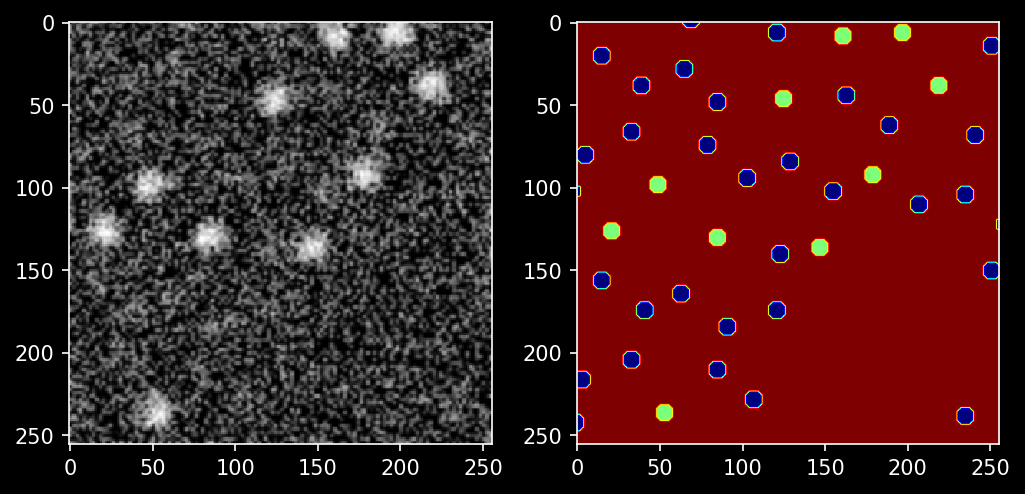

In [0]:
k = 1458
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=150)
ax1.imshow(X_train_[k, 0, :, :], cmap ='gray')
ax2.imshow(y_train_[k, :, :], cmap = 'jet', Interpolation='Gaussian')

Split into train-test sets:

In [0]:
from sklearn.model_selection import train_test_split
X_train_, X_test_, y_train_, y_test_ = train_test_split(
    X_train_, y_train_, test_size=0.2, random_state=42, shuffle=True)
print(X_train_.shape, y_train_.shape, np.unique(y_train_))

(1200, 1, 256, 256) (1200, 256, 256) [0. 1. 2.]


Save as hdf5 file:

In [0]:
with h5py.File('GSi-m7.hdf5', 'w') as f:
    f.create_dataset('X_train', data = X_train_, maxshape=(
        None, X_train_.shape[1], X_train_.shape[2], X_train_.shape[3]))
    f.create_dataset('y_train', data = y_train_, maxshape=(
        None, y_train_.shape[1], y_train_.shape[2])) 
    f.create_dataset('X_test', data = X_test_, maxshape=(
        None, X_test_.shape[1], X_test_.shape[2], X_test_.shape[3]))
    f.create_dataset('y_test', data = y_test_, maxshape=(
        None, y_test_.shape[1], y_test_.shape[2])) 

Or append to existing hdf5 file:

In [0]:
import h5py
with h5py.File('GSi-m6.hdf5', 'a') as hf:
    hf["X_train"].resize((hf["X_train"].shape[0] + X_train_.shape[0]), axis = 0)
    hf["X_train"][-X_train_.shape[0]:] = X_train_

    hf["X_test"].resize((hf["X_test"].shape[0] + X_test_.shape[0]), axis = 0)
    hf["X_test"][-X_test_.shape[0]:] = X_test_

    hf["y_train"].resize((hf["y_train"].shape[0] + y_train_.shape[0]), axis = 0)
    hf["y_train"][-y_train_.shape[0]:] = y_train_

    hf["y_test"].resize((hf["y_test"].shape[0] + y_test_.shape[0]), axis = 0)
    hf["y_test"][-y_test_.shape[0]:] = y_test_